In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [5]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (185, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-185, 50),
}

In [6]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = ((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x
        unbinned_y = ((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
        # Percentage of whole zone (not in comparison with league average)
        copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage

    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [25]:
import matplotlib.path as mpath
from matplotlib.colors import colorConverter
def get_smooth_square():
    """
    Creates marker which represents smooth square.

    :return: new matplotlib.path.Path instance
    """
    marker = np.array([[-0.8, 1.0],
                       [-1.0, 0.8],
                       [-1.0, -0.8],
                       [-0.8, -1.0],
                       [0.8, -1.0],
                       [1.0, -0.8],
                       [1.0, 0.8],
                       [0.8, 1.0],
                       [-0.8, 1.0]])

    return mpath.Path(marker, closed=True)

def plot_shotchart(
    original_df,
    data_frame,
    title,
    mode='light',
    plot_text=False,
    drop_single_shots=False,
    plot_attempts=False,
    unassisted_dict=None,
    season=None
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    # colors_dict = {0:'red', 1:'green'}
    cmap_list = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"],n_colors=21, as_cmap=False)

    
    # LOC_PERCENTAGE -> total perc
    # PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
    # PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
    # LOC_X, LOC_Y -> real locs
    # BIN_LOC_X, BIN_LOC_Y -> binned locations
    fontsize = 18
    title_size = 48
    
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    marker = get_smooth_square()
    edge_color = colorConverter.to_rgba('black', alpha=.5)
    dropped_dups = data_frame.drop_duplicates(subset=['BIN_LOC_X', 'BIN_LOC_Y'], keep='first')
    if drop_single_shots:
        dropped_dups = dropped_dups.loc[dropped_dups.LOC_RAW_COUNTS > 1]
    
    colors = [cmap_list[int(item)+10] for item in dropped_dups.PCT_LEAGUE_COMPARISON_ZONE.tolist()]
    paths = ax.scatter(
        x=dropped_dups.BIN_LOC_X,
        y=dropped_dups.BIN_LOC_Y,
        marker=marker,
        s=dropped_dups.LOC_COUNTS * 6,
        c=colors,
        #cmap=colors,
        edgecolors='black',
        lw=0.5
    )

    if mode == 'dark':
        background_color="#000000"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    # Frequency
    
    text_y = 385
    size_modifier = 50

    ax.text(x=-240, y=360, s="Less\nFrequent", color=bball_white, fontsize=fontsize)
    ax.scatter(x=-218, y=text_y, s=size_modifier * 1 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-205, y=text_y, s=size_modifier * 3 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-190, y=text_y, s=size_modifier * 6 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-171, y=text_y, s=size_modifier * 9 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-151, y=text_y, s=size_modifier * 11 * 2.5, marker=marker, c=bball_white)
    ax.text(x=-153, y=360, s="      More\nFrequent", color=bball_white, fontsize=fontsize)


    # Efficiency

    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_white, fontsize=fontsize, ha='center')
    ax.text(x=95, y=360, s="Below\nAverage", color=bball_white, fontsize=fontsize)
    ax.scatter(x=130, y=text_y, s=1050, marker=marker, c="#4159E1", edgecolors=bball_white)
    ax.scatter(x=147, y=text_y, s=1050, marker=marker, c="#B0E0E6", edgecolors=bball_white)
    ax.scatter(x=164, y=text_y, s=1050, marker=marker, c="#FFFF99", edgecolors=bball_white)
    ax.scatter(x=181, y=text_y, s=1050, marker=marker, c="#EF3330", edgecolors=bball_white)
    ax.scatter(x=198, y=text_y, s=1050, marker=marker, c="#AB2020", edgecolors=bball_white)
    ax.text(x=201, y=360, s="   Above\nAverage", color=bball_white, fontsize=fontsize)
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        if df_by_zone_median.iloc[index].name not in text_location_mapping:
            continue
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        key = df_by_zone_median.iloc[index].name
        binned_data = dropped_dups.loc[
            (dropped_dups.SHOT_ZONE_BASIC == key[0]) & 
            (dropped_dups.SHOT_ZONE_AREA == key[1]) & 
            (dropped_dups.SHOT_ZONE_RANGE == key[2])]
        if len(binned_data) < 3:
            continue
        if zone_shots_attempted < 5:
            continue
        if plot_attempts:
            cur_key = df_by_zone_median.iloc[index].name
            if unassisted_dict is not None and cur_key in unassisted_dict:
                unassissted_pct = unassisted_dict[cur_key]
                target_string = f"{int(zone_shots_made)}/{int(zone_shots_attempted)}({zone_percentage:.1f}%)\nUAST%: {unassissted_pct:.1f}%"
                ax.text(x=x, y=y, s=target_string, ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
            else:
                ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}\n{zone_percentage:.2f}%", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
        else:
            ax.text(x=x, y=y, s=f"{zone_percentage:.2f}%", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
        
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    ax.set_frame_on(False)
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    if season is not None:
        player_id = original_df.iloc[0].PLAYER_ID
        ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (172, -7.25), frameon=False)
        #ab = AnnotationBbox(OffsetImage(img, zoom=1.0), (172, -7.5), frameon=False)
        ax.add_artist(ab)
    # Title
    ax.set_title(title, size=title_size, color=bball_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-252,252)
    ax.set_ylim(-65,423)

    return dropped_dups, df_by_zone_sum

In [19]:
import matplotlib.path as mpath
from matplotlib.colors import colorConverter
def get_smooth_square():
    """
    Creates marker which represents smooth square.

    :return: new matplotlib.path.Path instance
    """
    marker = np.array([[-0.8, 1.0],
                       [-1.0, 0.8],
                       [-1.0, -0.8],
                       [-0.8, -1.0],
                       [0.8, -1.0],
                       [1.0, -0.8],
                       [1.0, 0.8],
                       [0.8, 1.0],
                       [-0.8, 1.0]])

    return mpath.Path(marker, closed=True)

def plot_shotchart_light(
    original_df,
    data_frame,
    title,
    mode='light',
    plot_text=False,
    drop_single_shots=False,
    plot_attempts=False,
    unassisted_dict=None,
    season=None
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    # colors_dict = {0:'red', 1:'green'}
    cmap_list = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"],n_colors=21, as_cmap=False)

    
    # LOC_PERCENTAGE -> total perc
    # PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
    # PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
    # LOC_X, LOC_Y -> real locs
    # BIN_LOC_X, BIN_LOC_Y -> binned locations
    fontsize = 18
    title_size = 48
    
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    marker = get_smooth_square()
    edge_color = colorConverter.to_rgba('black', alpha=.5)
    dropped_dups = data_frame.drop_duplicates(subset=['BIN_LOC_X', 'BIN_LOC_Y'], keep='first')
    if drop_single_shots:
        dropped_dups = dropped_dups.loc[dropped_dups.LOC_RAW_COUNTS > 1]
    
    colors = [cmap_list[int(item)+10] for item in dropped_dups.PCT_LEAGUE_COMPARISON_ZONE.tolist()]
    paths = ax.scatter(
        x=dropped_dups.BIN_LOC_X,
        y=dropped_dups.BIN_LOC_Y,
        marker=marker,
        s=dropped_dups.LOC_COUNTS * 6,
        c=colors,
        #cmap=colors,
        edgecolors='black',
        lw=0.5
    )

    if mode == 'dark':
        background_color="#000000"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    # Frequency
    
    text_y = 385
    size_modifier = 50

    ax.text(x=-240, y=360, s="Less\nFrequent", color=bball_gray, fontsize=fontsize)
    ax.scatter(x=-218, y=text_y, s=size_modifier * 1 * 2.5, marker=marker, c=bball_gray)
    ax.scatter(x=-205, y=text_y, s=size_modifier * 3 * 2.5, marker=marker, c=bball_gray)
    ax.scatter(x=-190, y=text_y, s=size_modifier * 6 * 2.5, marker=marker, c=bball_gray)
    ax.scatter(x=-171, y=text_y, s=size_modifier * 9 * 2.5, marker=marker, c=bball_gray)
    ax.scatter(x=-151, y=text_y, s=size_modifier * 11 * 2.5, marker=marker, c=bball_gray)
    ax.text(x=-153, y=360, s="      More\nFrequent", color=bball_gray, fontsize=fontsize)


    # Efficiency

    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_gray, fontsize=fontsize, ha='center')
    ax.text(x=95, y=360, s="Below\nAverage", color=bball_gray, fontsize=fontsize)
    ax.scatter(x=130, y=text_y, s=1050, marker=marker, c="#4159E1", edgecolors=bball_gray)
    ax.scatter(x=147, y=text_y, s=1050, marker=marker, c="#B0E0E6", edgecolors=bball_gray)
    ax.scatter(x=164, y=text_y, s=1050, marker=marker, c="#FFFF99", edgecolors=bball_gray)
    ax.scatter(x=181, y=text_y, s=1050, marker=marker, c="#EF3330", edgecolors=bball_gray)
    ax.scatter(x=198, y=text_y, s=1050, marker=marker, c="#AB2020", edgecolors=bball_gray)
    ax.text(x=201, y=360, s="   Above\nAverage", color=bball_gray, fontsize=fontsize)
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        if df_by_zone_median.iloc[index].name not in text_location_mapping:
            continue
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        key = df_by_zone_median.iloc[index].name
        binned_data = dropped_dups.loc[
            (dropped_dups.SHOT_ZONE_BASIC == key[0]) & 
            (dropped_dups.SHOT_ZONE_AREA == key[1]) & 
            (dropped_dups.SHOT_ZONE_RANGE == key[2])]
        if len(binned_data) < 3:
            continue
        if zone_shots_attempted < 5:
            continue
        if plot_attempts:
            cur_key = df_by_zone_median.iloc[index].name
            if unassisted_dict is not None and cur_key in unassisted_dict:
                unassissted_pct = unassisted_dict[cur_key]
                target_string = f"{int(zone_shots_made)}/{int(zone_shots_attempted)}({zone_percentage:.1f}%)\nUAST%: {unassissted_pct:.1f}%"
                ax.text(x=x, y=y, s=target_string, ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
            else:
                ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}\n{zone_percentage:.2f}%", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
        else:
            ax.text(x=x, y=y, s=f"{zone_percentage:.2f}%", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, size=fontsize-2)
        
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    ax.set_frame_on(False)
    
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)
    player_id = original_df.iloc[0].PLAYER_ID
    target_dir = 'player_imgs'
    if f"{player_id}.png" not in os.listdir(target_dir):
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        with open(f'player_imgs/{player_id}.png', 'wb') as f:
            f.write(response.content)
    if season is not None:
        ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (172, -8), frameon=False)
        #ab = AnnotationBbox(OffsetImage(img, zoom=1.0), (172, -7.5), frameon=False)
        ax.add_artist(ab)
    # Title
    ax.set_title(title, size=title_size, color=bball_gray)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_gray)
    ax.set_xlim(-252,252)
    ax.set_ylim(-65,423)
    ax.text(x=220, y=-55, s='twitter: @daniel_bratulic', ha='right', size=14, color=bball_gray)
    ax.text(x=-220, y=-55, s='source: stats.nba.com', ha='left', size=14, color=bball_gray)

    return dropped_dups, df_by_zone_sum

In [20]:
def plot_zones_only(
        data_frame,
        title,
        player_id=None,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False
):
    original_df = data_frame
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    #data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    

    for index in range(len(data_frame)):
        cur_item = data_frame.iloc[index]
        key = (cur_item.SHOT_ZONE_BASIC, cur_item.SHOT_ZONE_AREA, cur_item.SHOT_ZONE_RANGE)
        x, y = text_location_mapping[key]
        ax.text(x=x, y=y, s=f"Unassisted\nRatio: {float(cur_item.SHOT_MADE_FLAG_UNASSISTED)/cur_item.TOTAL*100:.2f}%", ha='center', c='black',
               bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, fontsize=16)

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    ax.set_frame_on(False)
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    
    # Legend
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    player_id = original_df.iloc[0].PLAYER_ID
    target_dir = 'player_imgs'
    if f"{player_id}.png" not in os.listdir(target_dir):
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        with open(f'player_imgs/{player_id}.png', 'wb') as f:
            f.write(response.content)
    ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (172, -7.5), frameon=False)
    ax.add_artist(ab)
    # Title
    ax.set_title(title, size=48, color=bball_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,425)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    

## Ray Allen

In [10]:
player_name = "Ray Allen"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2005-06')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

#player_df = player_df.loc[player_df.GAME_ID.isin(player_df.GAME_ID.unique().tolist()[-15:])]


In [11]:
league_avg = player_shotchart.get_data_frames()[1]

binned_df = create_bins(data_frame=player_df, league_average=league_avg)

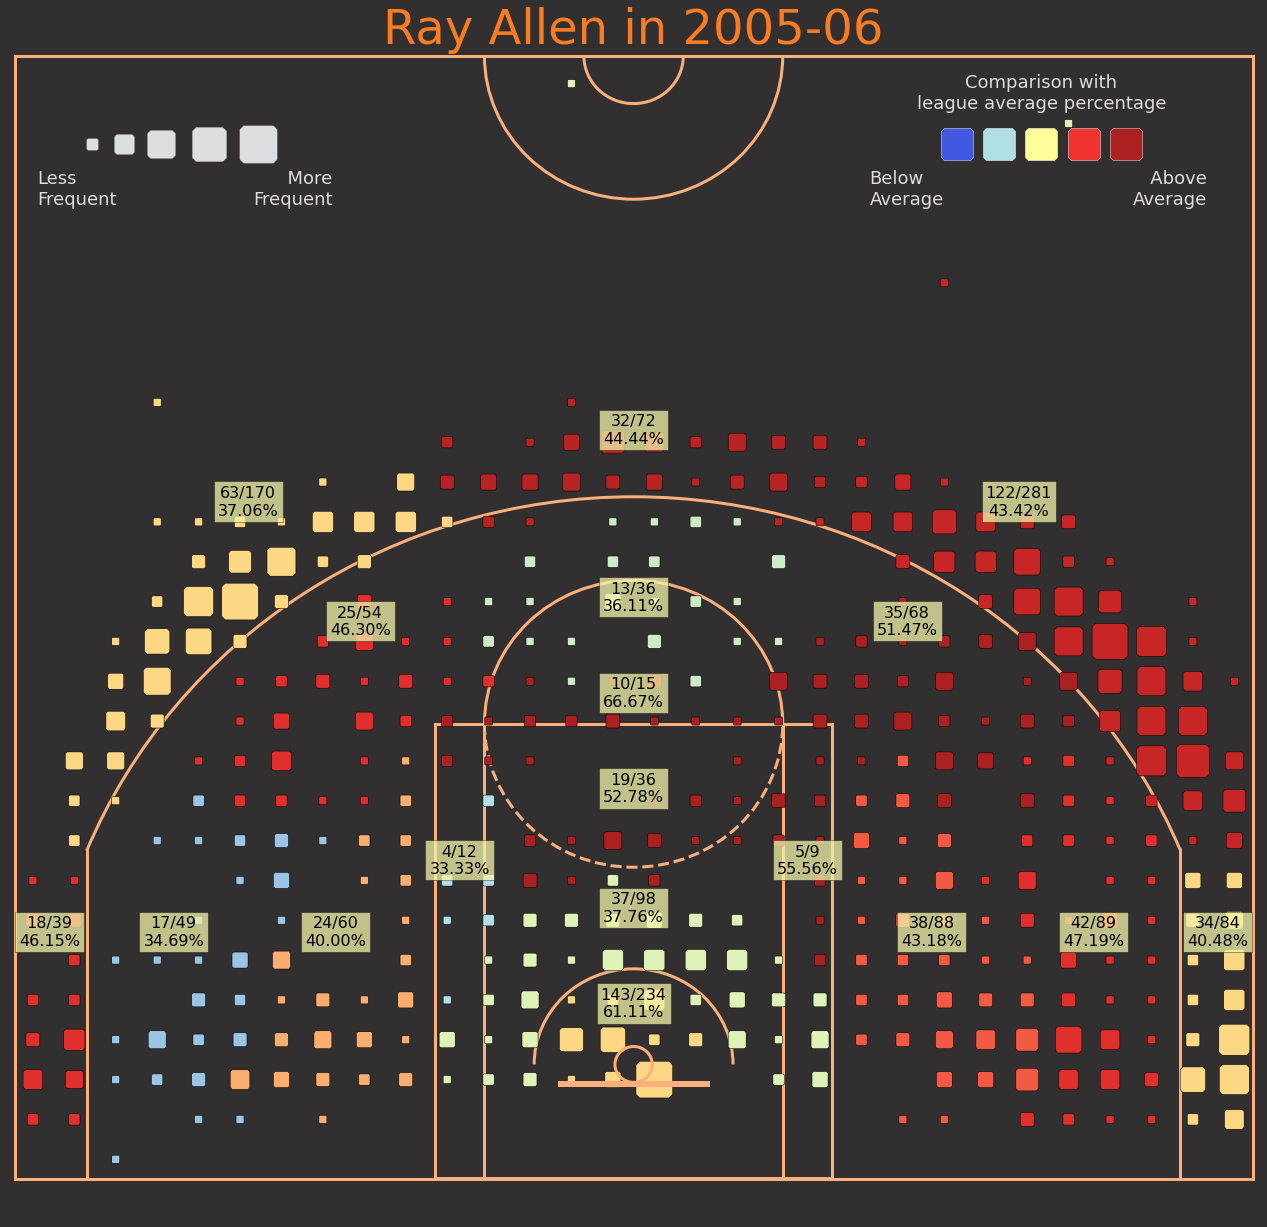

In [26]:
_ = plot_shotchart(player_df, binned_df, title='Ray Allen in 2005-06', plot_attempts=True)

## Joel Embiid

In [40]:
player_name = "Joel Embiid"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

#player_df = player_df.loc[player_df.GAME_ID.isin(player_df.GAME_ID.unique().tolist()[-15:])]


In [41]:
league_avg = player_shotchart.get_data_frames()[1]

In [42]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

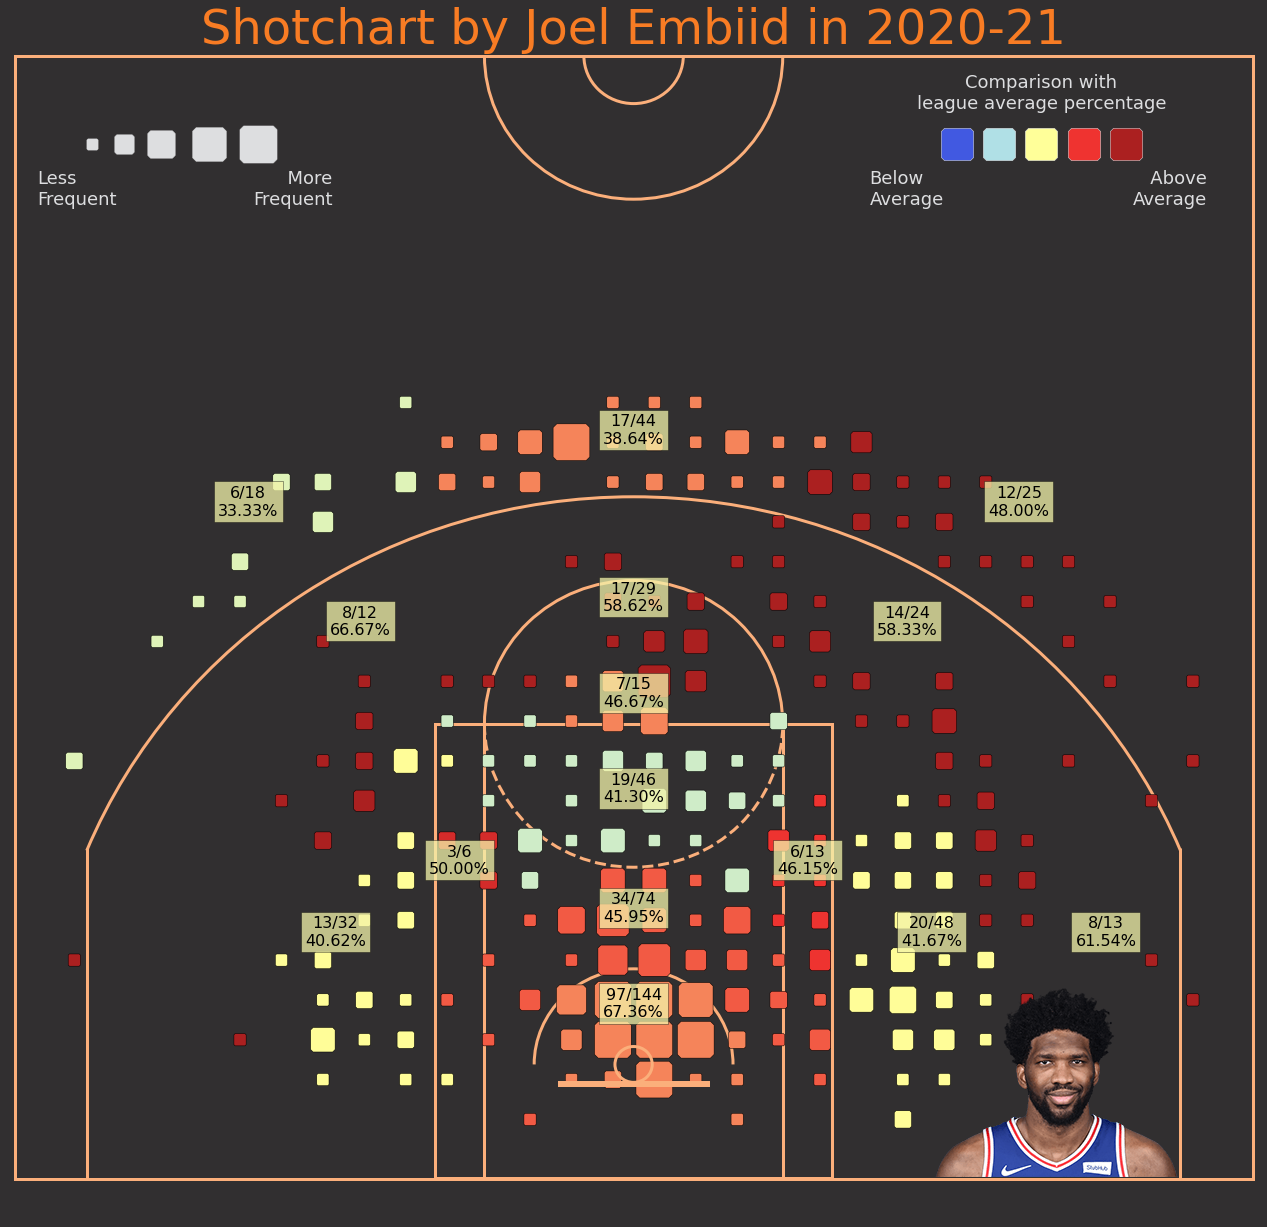

In [47]:
_ = plot_shotchart(player_df, binned_df, title='Shotchart by Joel Embiid in 2020-21', season='2020-21', plot_attempts=True)

## Chris Paul

In [9]:
player_name = "Chris Paul"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

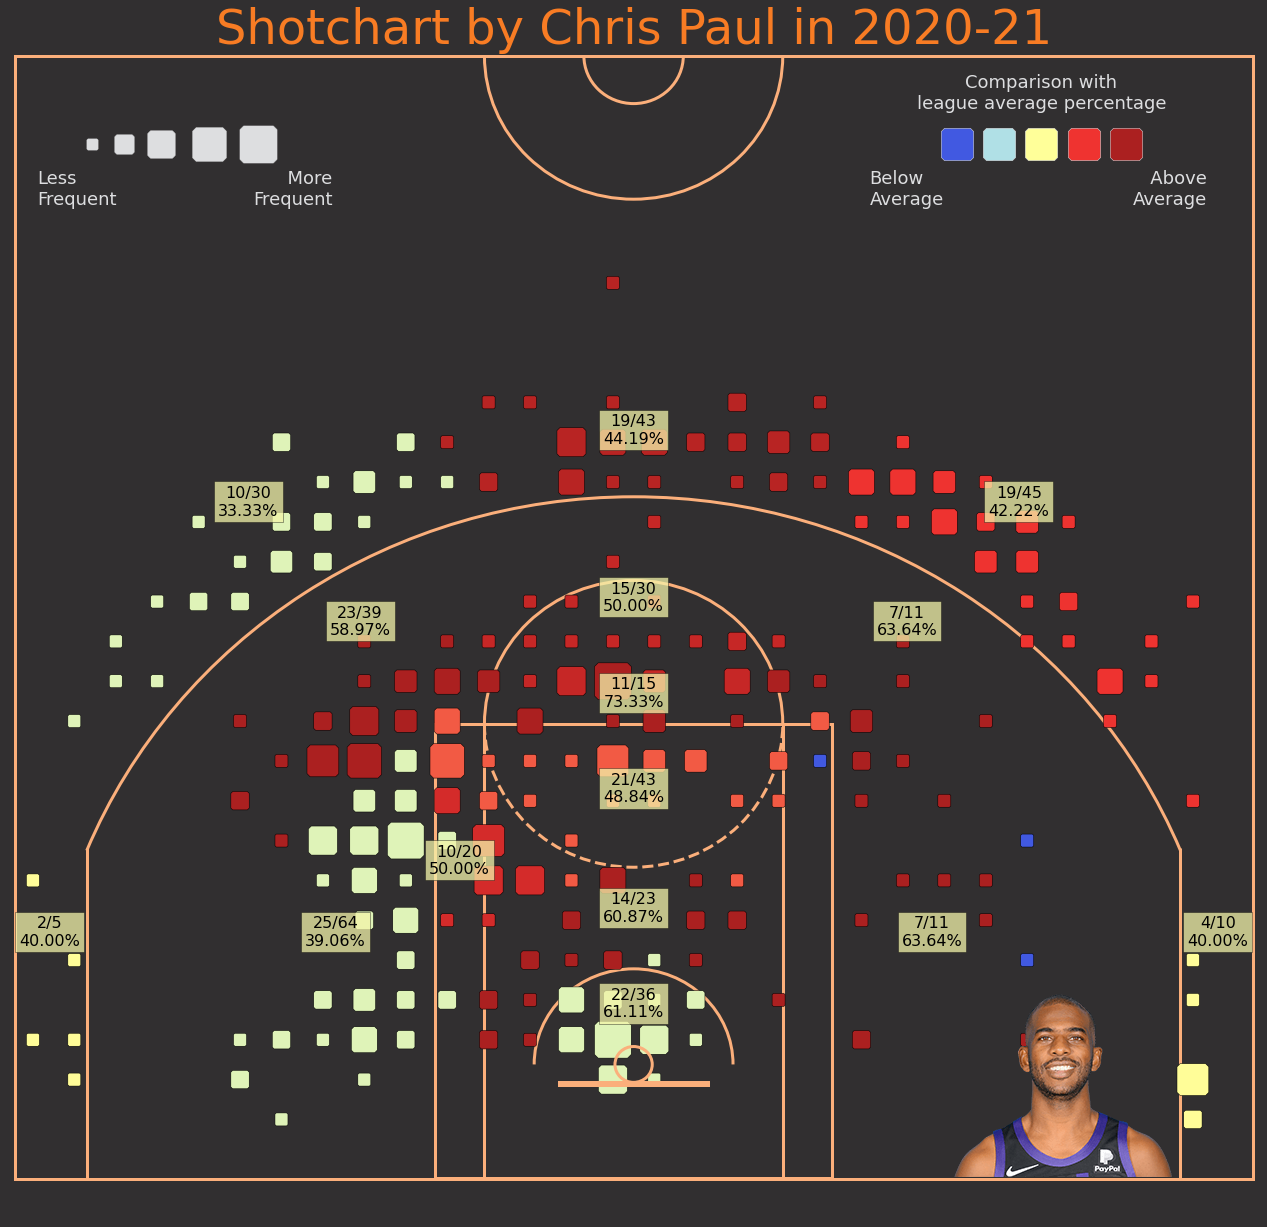

In [10]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(player_df, binned_df, title=f'Shotchart by {player_name} in 2020-21', season='2020-21', plot_attempts=True)

## Nikola Jokić

In [55]:
player_name = "Nikola Jokic"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

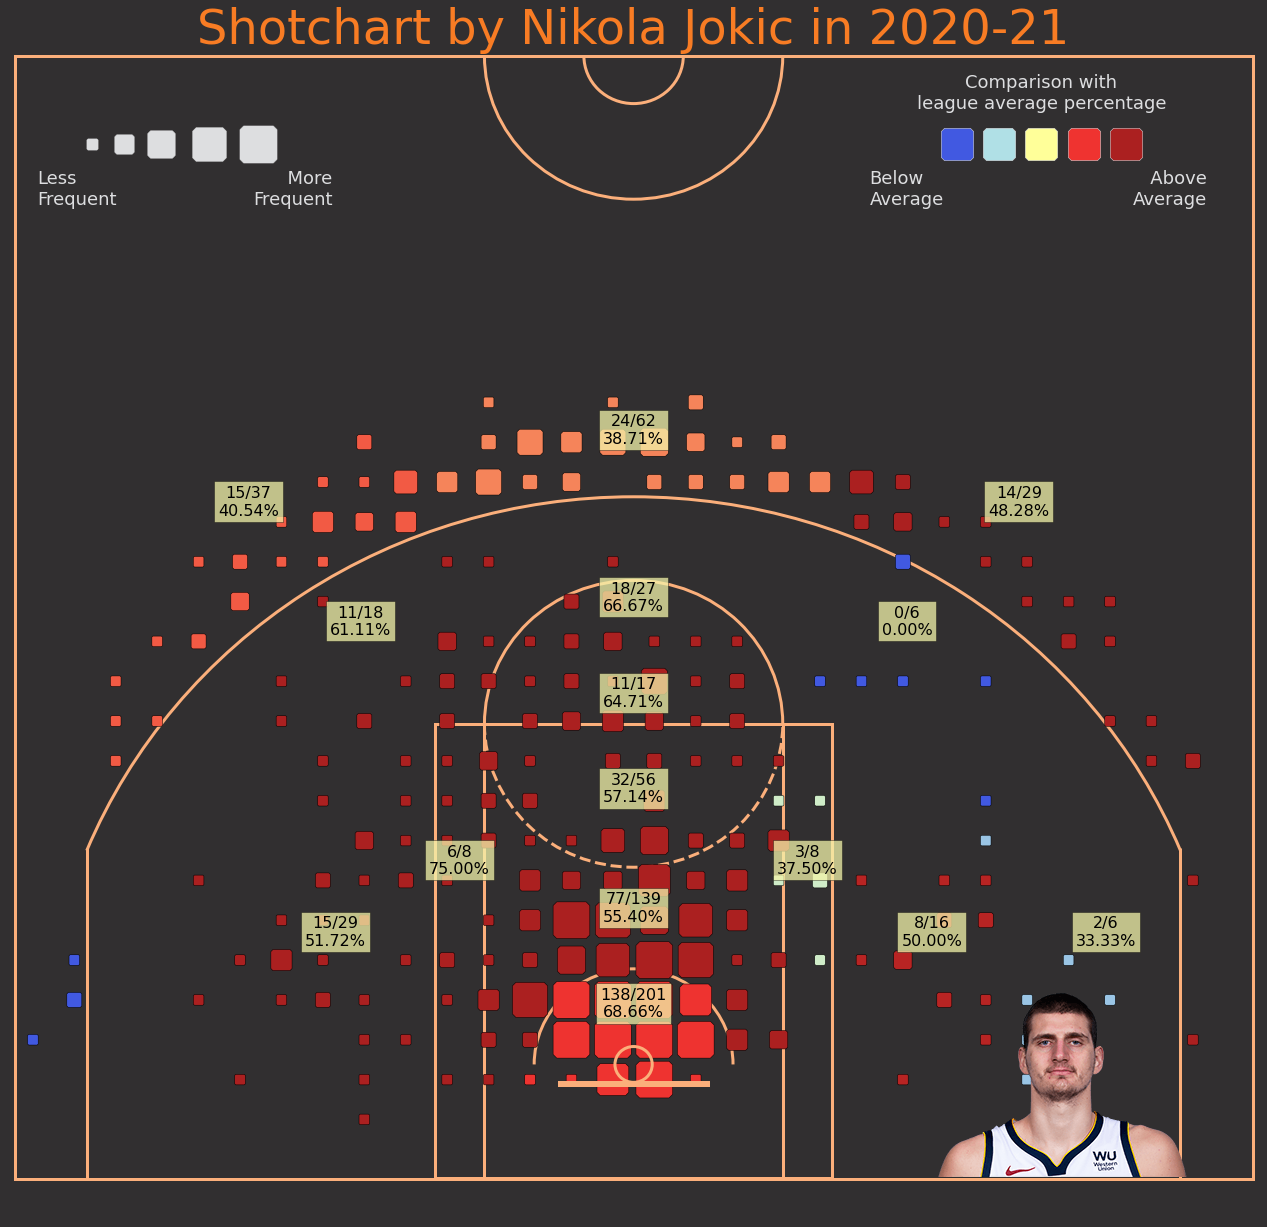

In [56]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(player_df, binned_df, title=f'Shotchart by {player_name} in 2020-21', season='2020-21', plot_attempts=True)

## Checking in on unassisted shots

In [12]:
pbp_df = pd.read_csv('../pbp_analysis/pbp_data/2020-21.csv')

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
pbp_df

EVENTMSGACTIONTYPE  EVENTMSGTYPE  EVENTNUM   GAME_ID  \
0                        0            12         2  22000267   
1                        0            10         4  22000267   
2                        1             2         7  22000267   
3                        0             4         8  22000267   
4                        1             2         9  22000267   
...                    ...           ...       ...       ...   
253852                  10             3       742  22000566   
253853                   0             4       743  22000566   
253854                   5             2       744  22000566   
253855                   0             4       746  22000566   
253856                   0            13       747  22000566   

                                          HOMEDESCRIPTION  \
0                                                     NaN   
1       Jump Ball Kanter vs. Roby: Tip to Gilgeous-Ale...   
2                                                     NaN   
3                           Anthony REBOUND (Off:0 Def:1)   
4                          MISS Anthony 26' 3PT Jump Shot   
...                                                   ...   
253852                 MISS Valanciunas Free Throw 1 of 1   
253853                                                NaN   
253854                          Valanciunas BLOCK (4 BLK)   
253855                         Bane REBOUND (Off:0 Def:4)   
253856                                                NaN   

                      NEUTRALDESCRIPTION  PCTIMESECONDS PCTIMESTRING  PERIOD  \
0                                    NaN              0        12:00       1   
1                                    NaN              0        12:00       1   
2                                    NaN             17        11:43       1   
3                                    NaN             19        11:41       1   
4                                    NaN             28        11:32       1   
...                                  ...            ...          ...     ...   
253852                               NaN            690         0:30       4   
253853                               NaN            693         0:27       4   
253854                               NaN            705         0:15       4   
253855                               NaN            709         0:11       4   
253856  End of 4th Period (10:25 PM EST)            720         0:00       4   

        PERSON1TYPE  ...             PLAYER3_NAME  PLAYER3_TEAM_ABBREVIATION  \
0               0.0  ...                      NaN                        NaN   
1               4.0  ...  Shai Gilgeous-Alexander                        OKC   
2               5.0  ...                      NaN                        NaN   
3               4.0  ...                      NaN                        NaN   
4               4.0  ...                      NaN                        NaN   
...             ...  ...                      ...                        ...   
253852          4.0  ...                      NaN                        NaN   
253853          5.0  ...                      NaN                        NaN   
253854          5.0  ...        Jonas Valanciunas                        MEM   
253855          4.0  ...                      NaN                        NaN   
253856          0.0  ...                      NaN                        NaN   

        PLAYER3_TEAM_CITY PLAYER3_TEAM_ID PLAYER3_TEAM_NICKNAME      SCORE  \
0                     NaN             NaN                   NaN        NaN   
1           Oklahoma City    1.610613e+09               Thunder        NaN   
2                     NaN             NaN                   NaN        NaN   
3                     NaN             NaN                   NaN        NaN   
4                     NaN             NaN                   NaN        NaN   
...                   ...             ...                   ...        ...   
253852                NaN             

In [14]:
pbp_df = pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]

## Nikola Jokic - Unassisted

In [20]:
player_name = "Nikola Jokic"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

player_shots = pd.merge(left=player_df, right=pbp_df, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

player_made = player_shots.loc[player_shots.SHOT_MADE_FLAG == 1]

player_assisted = player_made.loc[player_made.PLAYER2_ID != 0]

player_unassisted = player_made.loc[player_made.PLAYER2_ID == 0]

player_unassisted_group = player_unassisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

player_assisted_group = player_assisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

merged_player = pd.merge(left=player_assisted_group, right=player_unassisted_group, how='outer', on=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], suffixes=('_ASSISTED', '_UNASSISTED'))

merged_player = merged_player.fillna(0)

merged_player.loc[:, 'TOTAL'] = merged_player.SHOT_MADE_FLAG_ASSISTED + merged_player.SHOT_MADE_FLAG_UNASSISTED
merged_player.loc[:, 'UNASSISTED_PCT'] = merged_player.SHOT_MADE_FLAG_UNASSISTED / merged_player.TOTAL
unassisted_dict = {}
for index in range(len(merged_player)):
    item = merged_player.iloc[index]
    unassisted_dict[(item.SHOT_ZONE_BASIC, item.SHOT_ZONE_AREA, item.SHOT_ZONE_RANGE)] = item.UNASSISTED_PCT  * 100

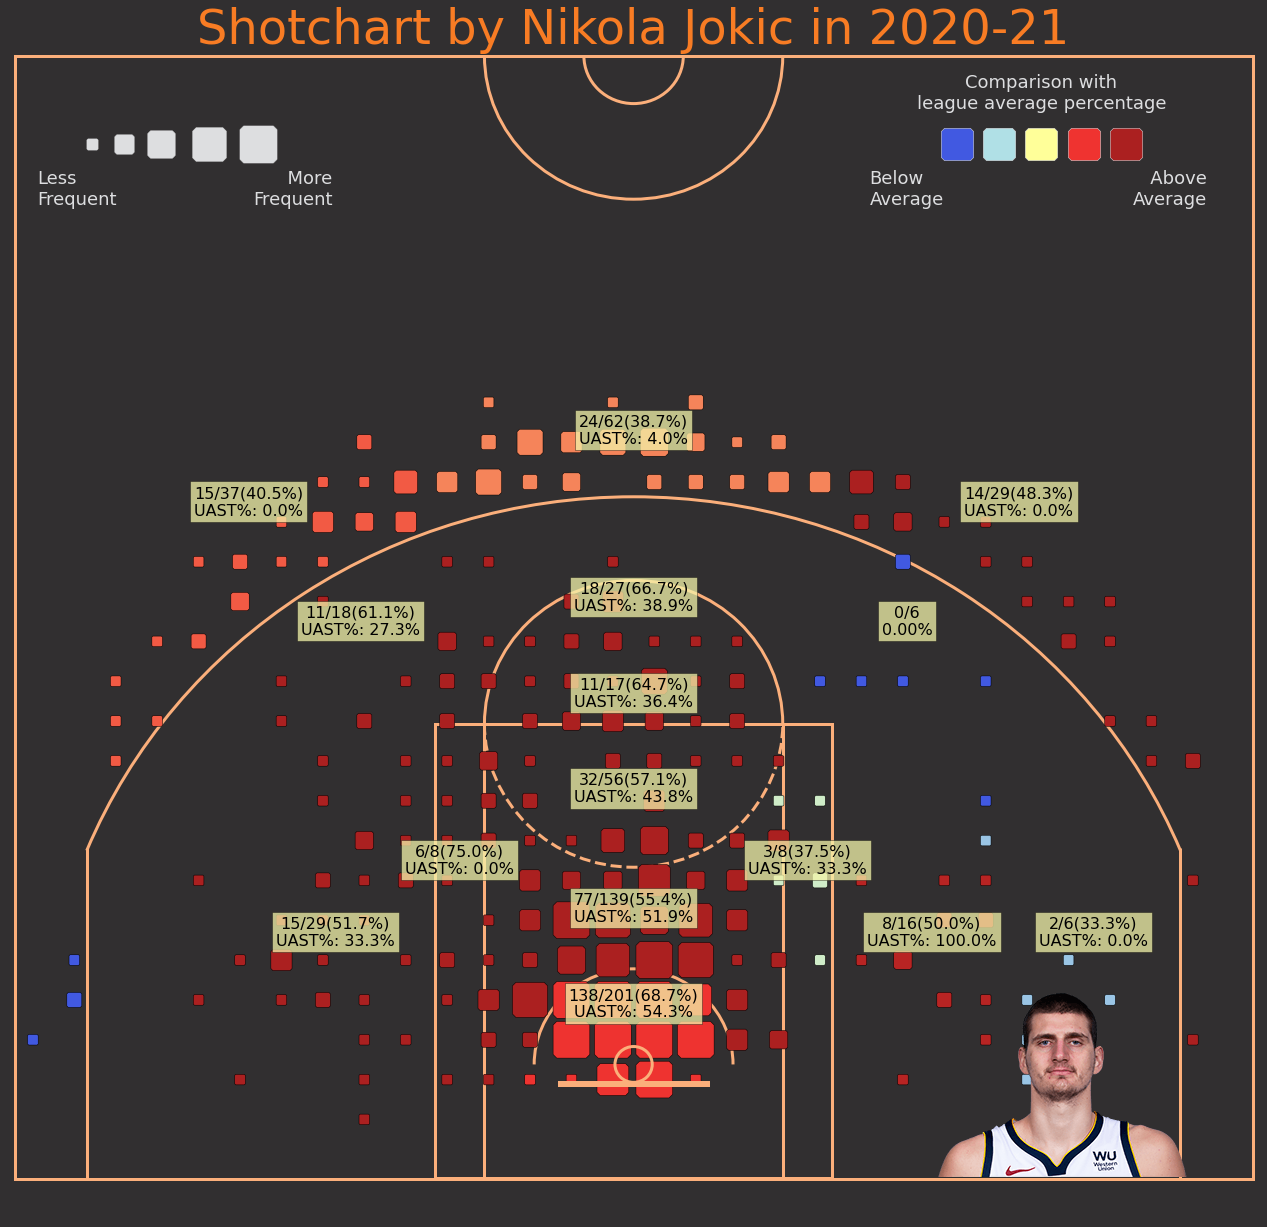

In [21]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(player_df, binned_df, title=f'Shotchart by {player_name} in 2020-21', season='2020-21', plot_attempts=True, unassisted_dict=unassisted_dict)

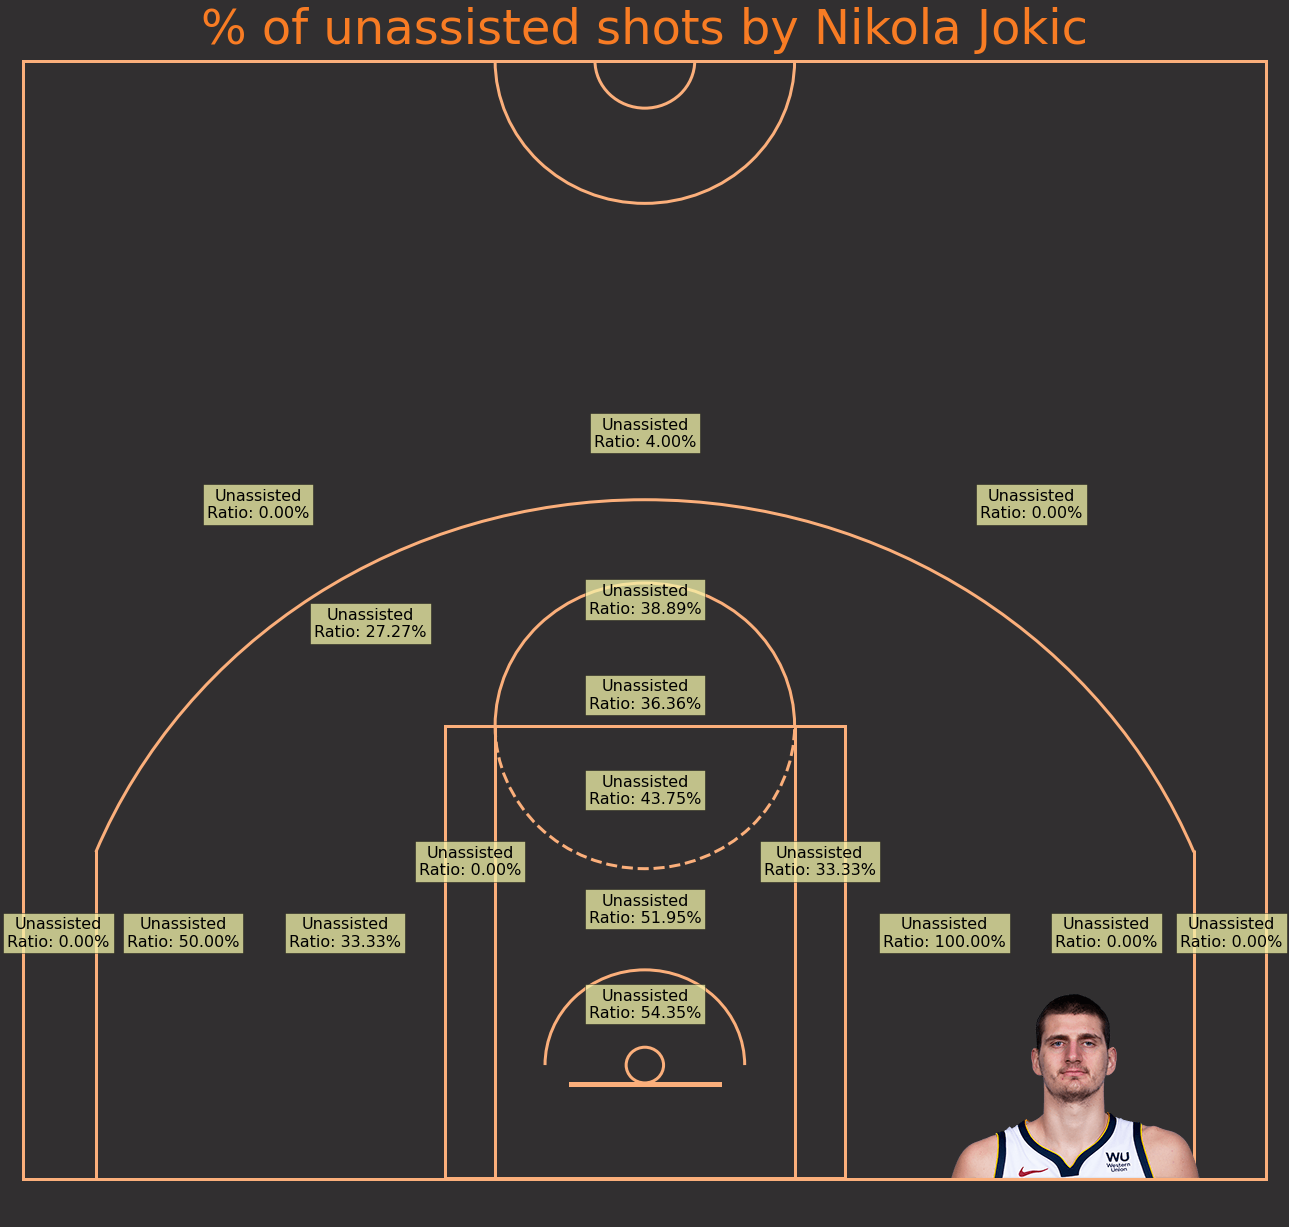

In [139]:
plot_zones_only(data_frame=merged_player, title=f"% of unassisted shots by {player_name}", player_id=player_id)

## Unassisted Joel Embiid

In [22]:
player_name = "Joel Embiid"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

player_shots = pd.merge(left=player_df, right=pbp_df, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

player_made = player_shots.loc[player_shots.SHOT_MADE_FLAG == 1]

player_assisted = player_made.loc[player_made.PLAYER2_ID != 0]

player_unassisted = player_made.loc[player_made.PLAYER2_ID == 0]

player_unassisted_group = player_unassisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

player_assisted_group = player_assisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

merged_player = pd.merge(left=player_assisted_group, right=player_unassisted_group, how='outer', on=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], suffixes=('_ASSISTED', '_UNASSISTED'))

merged_player = merged_player.fillna(0)

merged_player.loc[:, 'TOTAL'] = merged_player.SHOT_MADE_FLAG_ASSISTED + merged_player.SHOT_MADE_FLAG_UNASSISTED
merged_player.loc[:, 'UNASSISTED_PCT'] = merged_player.SHOT_MADE_FLAG_UNASSISTED / merged_player.TOTAL
unassisted_dict = {}
for index in range(len(merged_player)):
    item = merged_player.iloc[index]
    unassisted_dict[(item.SHOT_ZONE_BASIC, item.SHOT_ZONE_AREA, item.SHOT_ZONE_RANGE)] = item.UNASSISTED_PCT  * 100

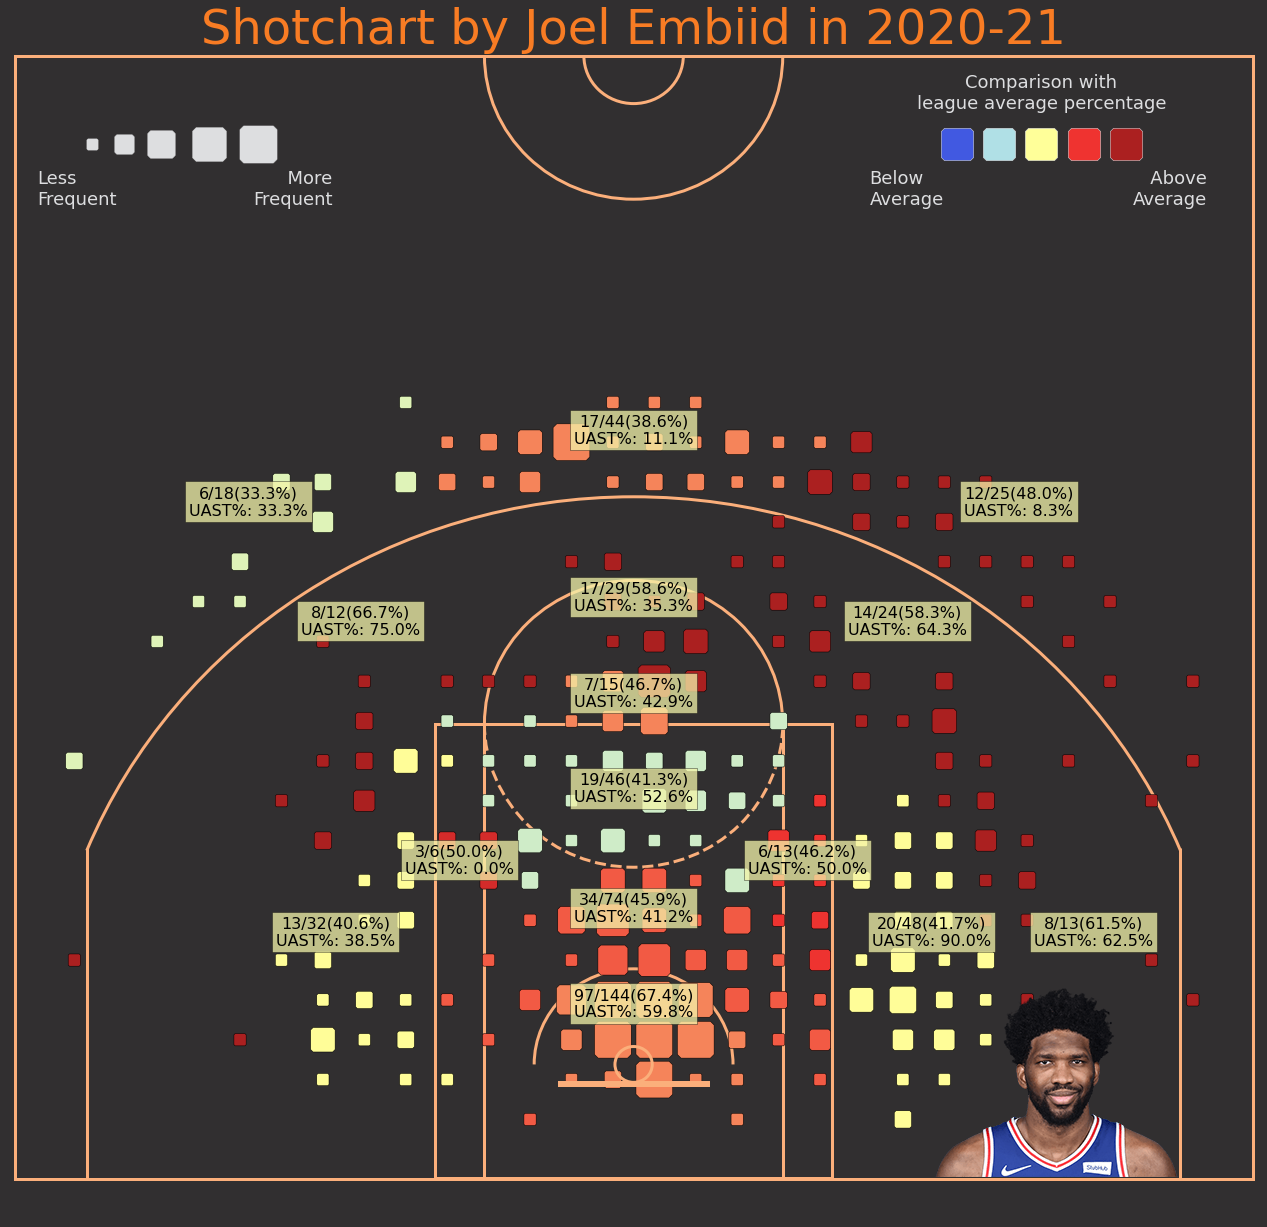

In [23]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(player_df, binned_df, title=f'Shotchart by {player_name} in 2020-21', season='2020-21', plot_attempts=True, unassisted_dict=unassisted_dict)

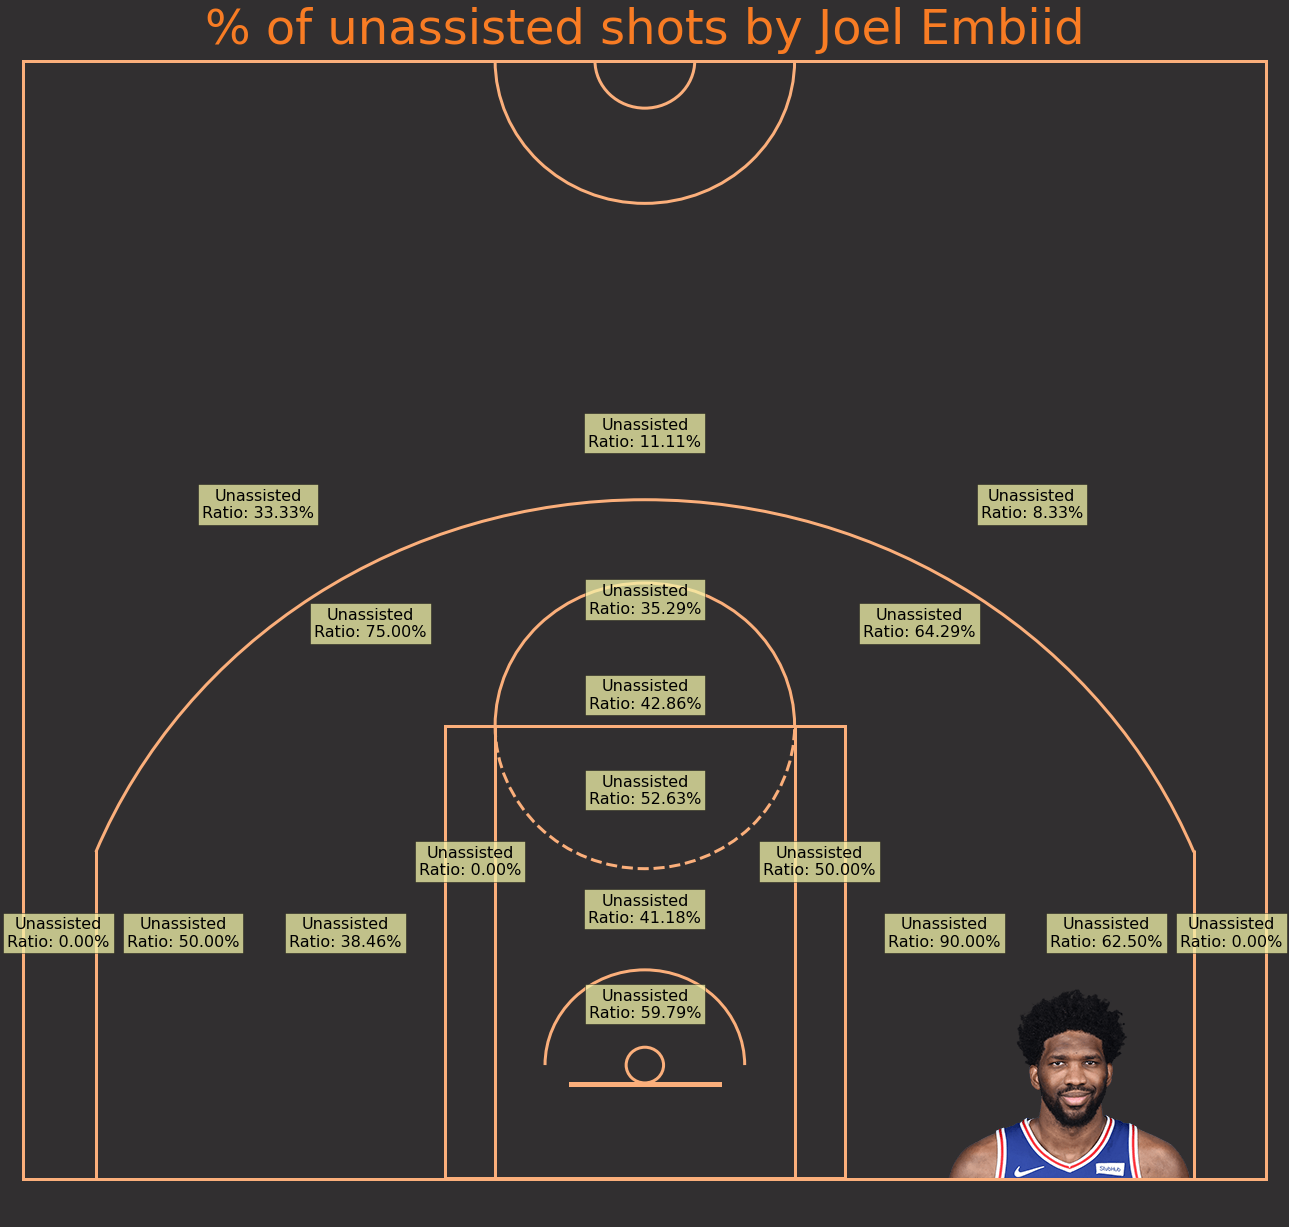

In [141]:
plot_zones_only(data_frame=merged_player, title=f"% of unassisted shots by {player_name}", player_id=player_id)

## Unassisted Chris Paul

In [15]:
player_name = "Chris Paul"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2020-21')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

player_shots = pd.merge(left=player_df, right=pbp_df, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

player_made = player_shots.loc[player_shots.SHOT_MADE_FLAG == 1]

player_assisted = player_made.loc[player_made.PLAYER2_ID != 0]

player_unassisted = player_made.loc[player_made.PLAYER2_ID == 0]

player_unassisted_group = player_unassisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

player_assisted_group = player_assisted.groupby(['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).agg(
    {
        'SHOT_MADE_FLAG': 'sum'
    }
).reset_index()

merged_player = pd.merge(left=player_assisted_group, right=player_unassisted_group, how='outer', on=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], suffixes=('_ASSISTED', '_UNASSISTED'))

merged_player = merged_player.fillna(0)

merged_player.loc[:, 'TOTAL'] = merged_player.SHOT_MADE_FLAG_ASSISTED + merged_player.SHOT_MADE_FLAG_UNASSISTED
merged_player.loc[:, 'UNASSISTED_PCT'] = merged_player.SHOT_MADE_FLAG_UNASSISTED / merged_player.TOTAL
unassisted_dict = {}
for index in range(len(merged_player)):
    item = merged_player.iloc[index]
    unassisted_dict[(item.SHOT_ZONE_BASIC, item.SHOT_ZONE_AREA, item.SHOT_ZONE_RANGE)] = item.UNASSISTED_PCT  * 100

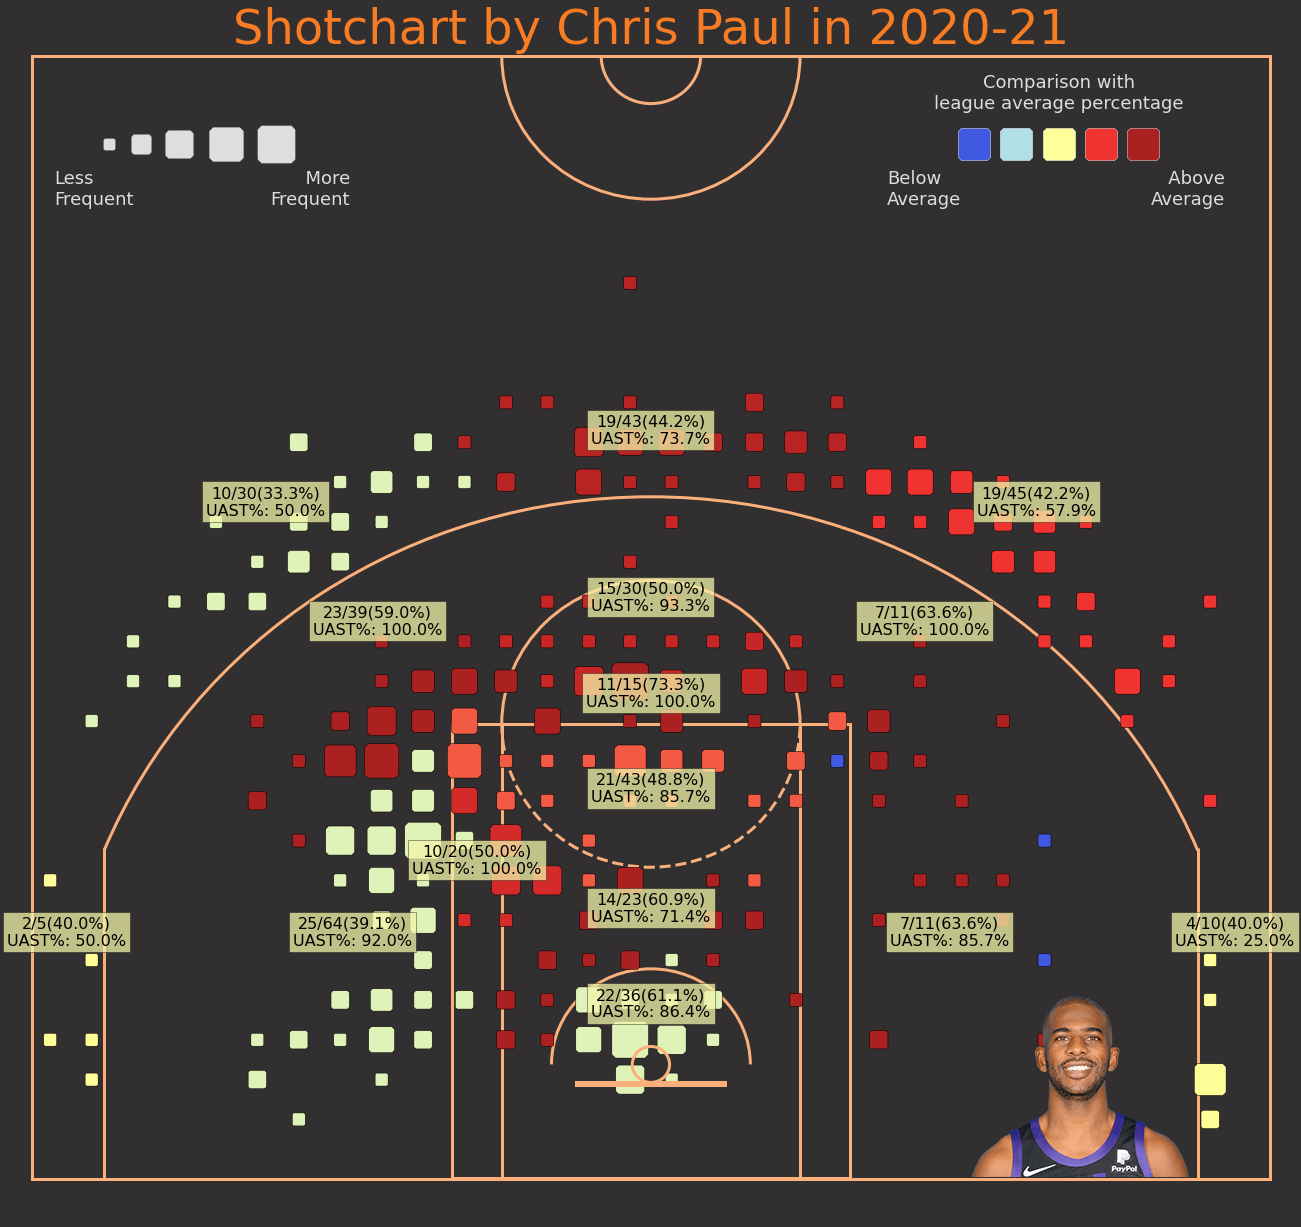

In [16]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(player_df, binned_df, title=f'Shotchart by {player_name} in 2020-21', season='2020-21', plot_attempts=True, unassisted_dict=unassisted_dict)

In [32]:
merged_player.loc[merged_player.SHOT_ZONE_BASIC == 'Mid-Range'].SHOT_MADE_FLAG_ASSISTED.sum()

4.0

In [34]:
merged_player.loc[merged_player.SHOT_ZONE_BASIC == 'Mid-Range'].TOTAL.sum()

88.0

In [33]:
merged_player.loc[merged_player.SHOT_ZONE_BASIC == 'Mid-Range']

SHOT_ZONE_BASIC         SHOT_ZONE_AREA SHOT_ZONE_RANGE  \
6        Mid-Range              Center(C)       16-24 ft.   
7        Mid-Range           Left Side(L)        8-16 ft.   
8        Mid-Range          Right Side(R)        8-16 ft.   
12       Mid-Range              Center(C)        8-16 ft.   
13       Mid-Range   Left Side Center(LC)       16-24 ft.   
14       Mid-Range  Right Side Center(RC)       16-24 ft.   
15       Mid-Range          Right Side(R)       16-24 ft.   

    SHOT_MADE_FLAG_ASSISTED  SHOT_MADE_FLAG_UNASSISTED  TOTAL  UNASSISTED_PCT  
6                       1.0                         14   15.0        0.933333  
7                       1.0                          6    7.0        0.857143  
8                       2.0                         21   23.0        0.913043  
12                      0.0                         11   11.0        1.000000  
13                      0.0                          7    7.0        1.000000  
14                      0.0                         23   23.0        1.000000  
15                      0.0                          2    2.0        1.000000

In [ ]:
merged_player.loc[merged_player.SHOT_ZONE_BASIC == 'Mid-Range'].SHOT_MADE_FLAG_ASSISTED.sum()

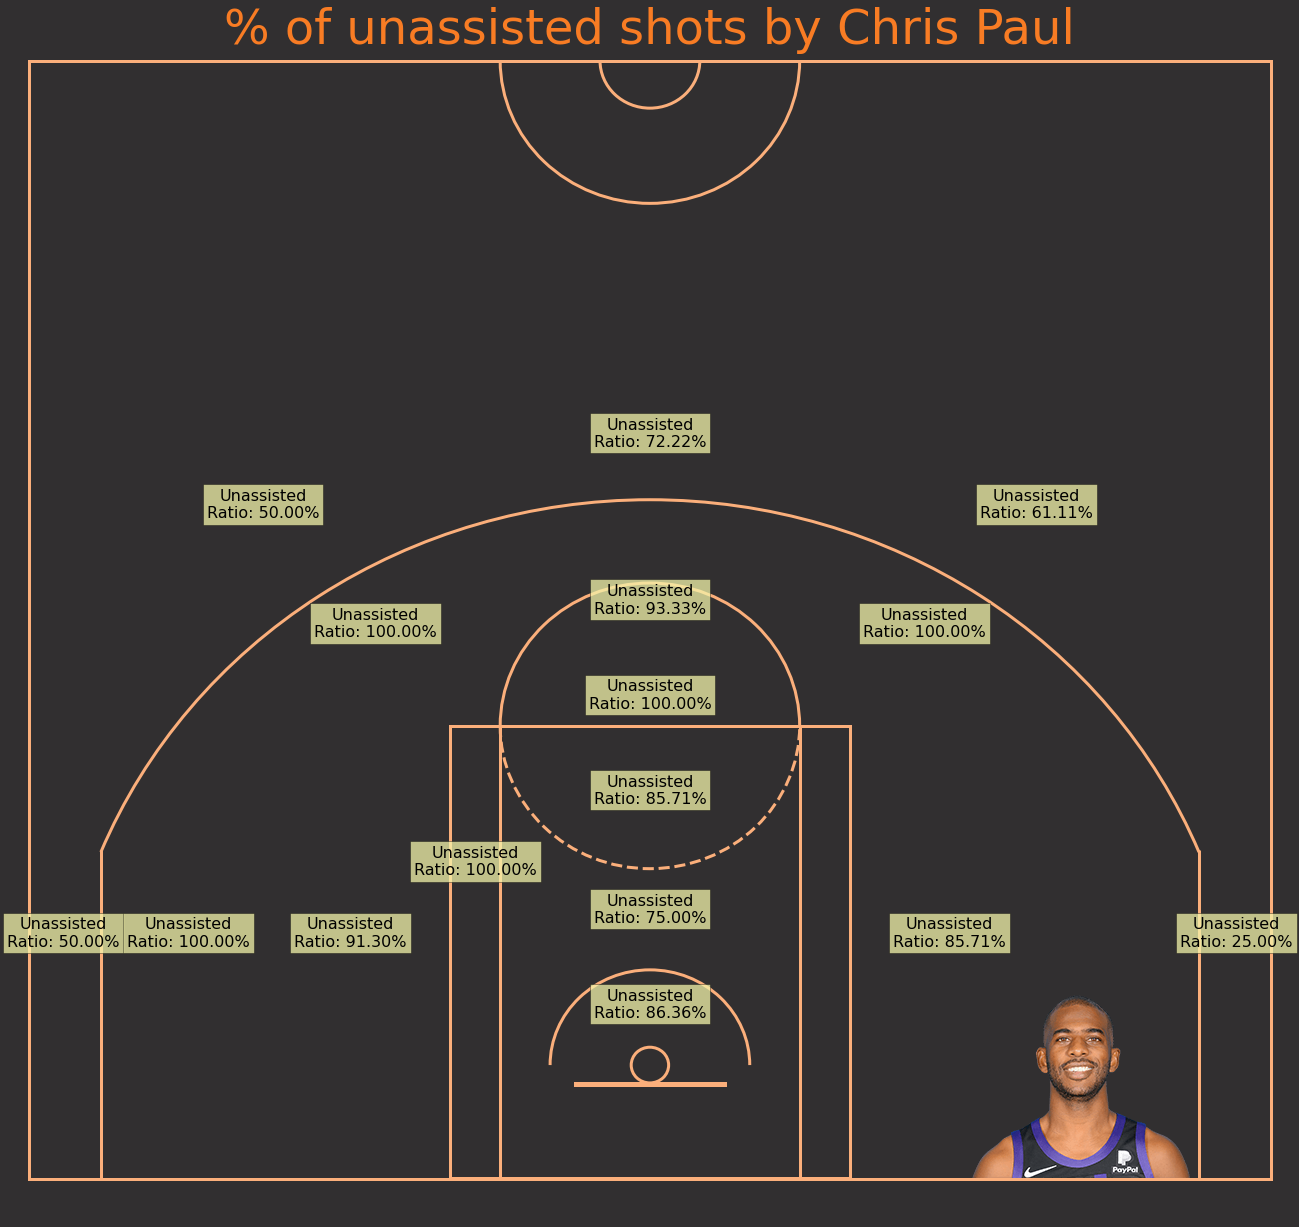

In [143]:
plot_zones_only(data_frame=merged_player, title=f"% of unassisted shots by {player_name}", player_id=player_id)

## LeBron

In [9]:
player_name = "LeBron James"
season = '2008-09'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [ ]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

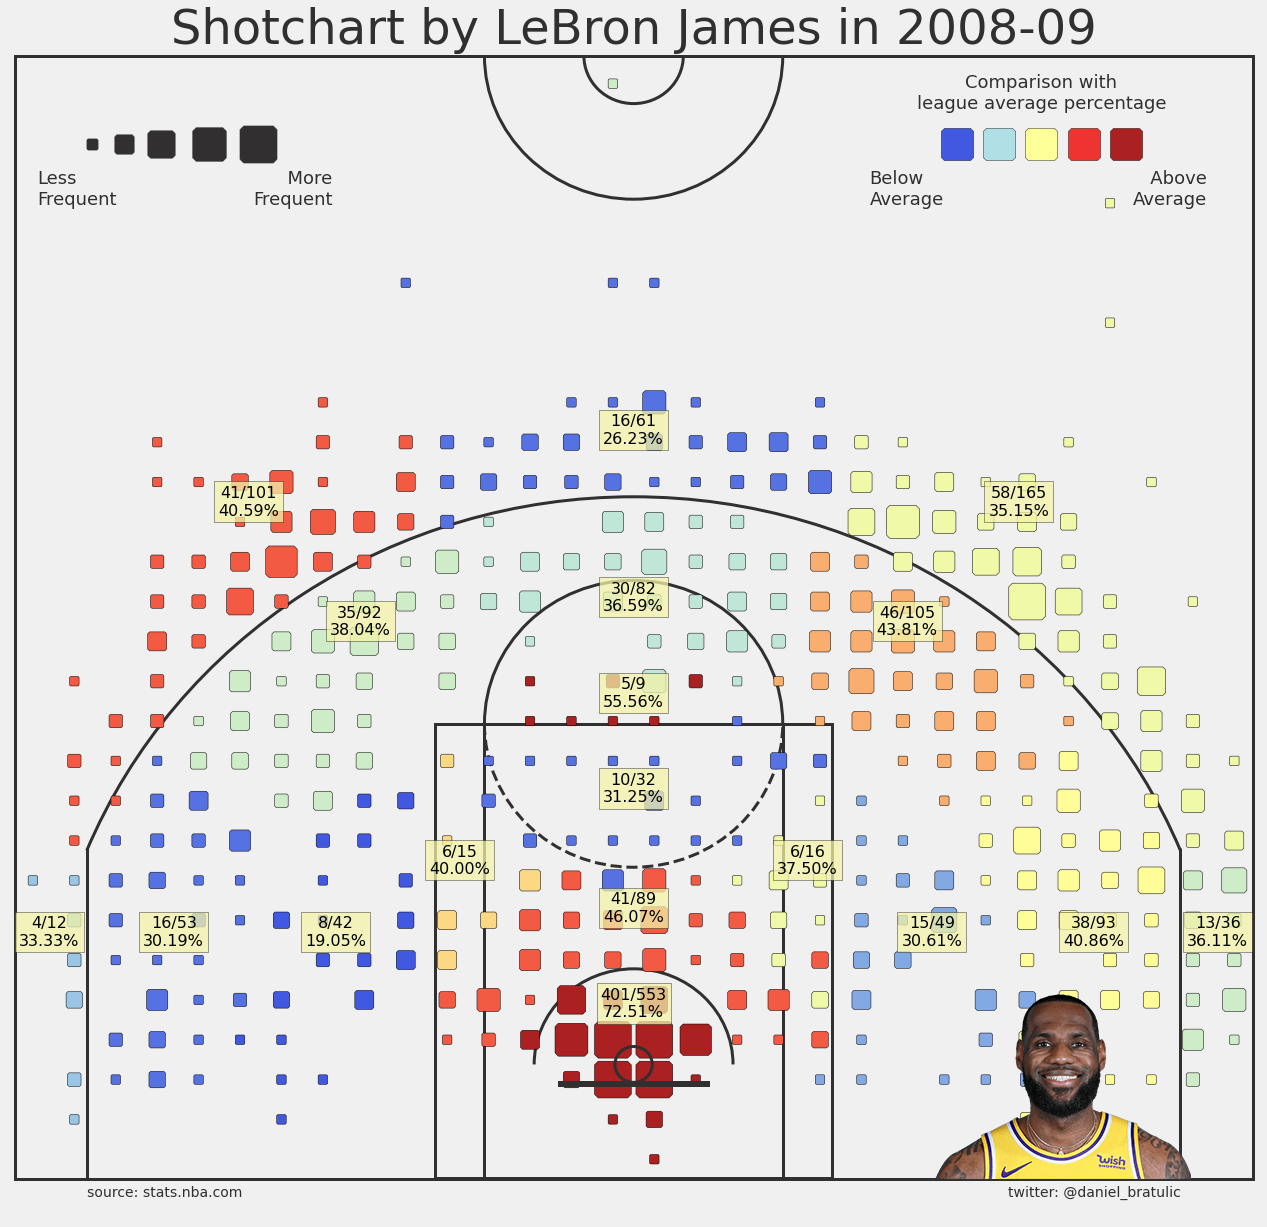

In [27]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)

### 2009-10

In [42]:
player_name = "LeBron James"
season = '2009-10'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [43]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

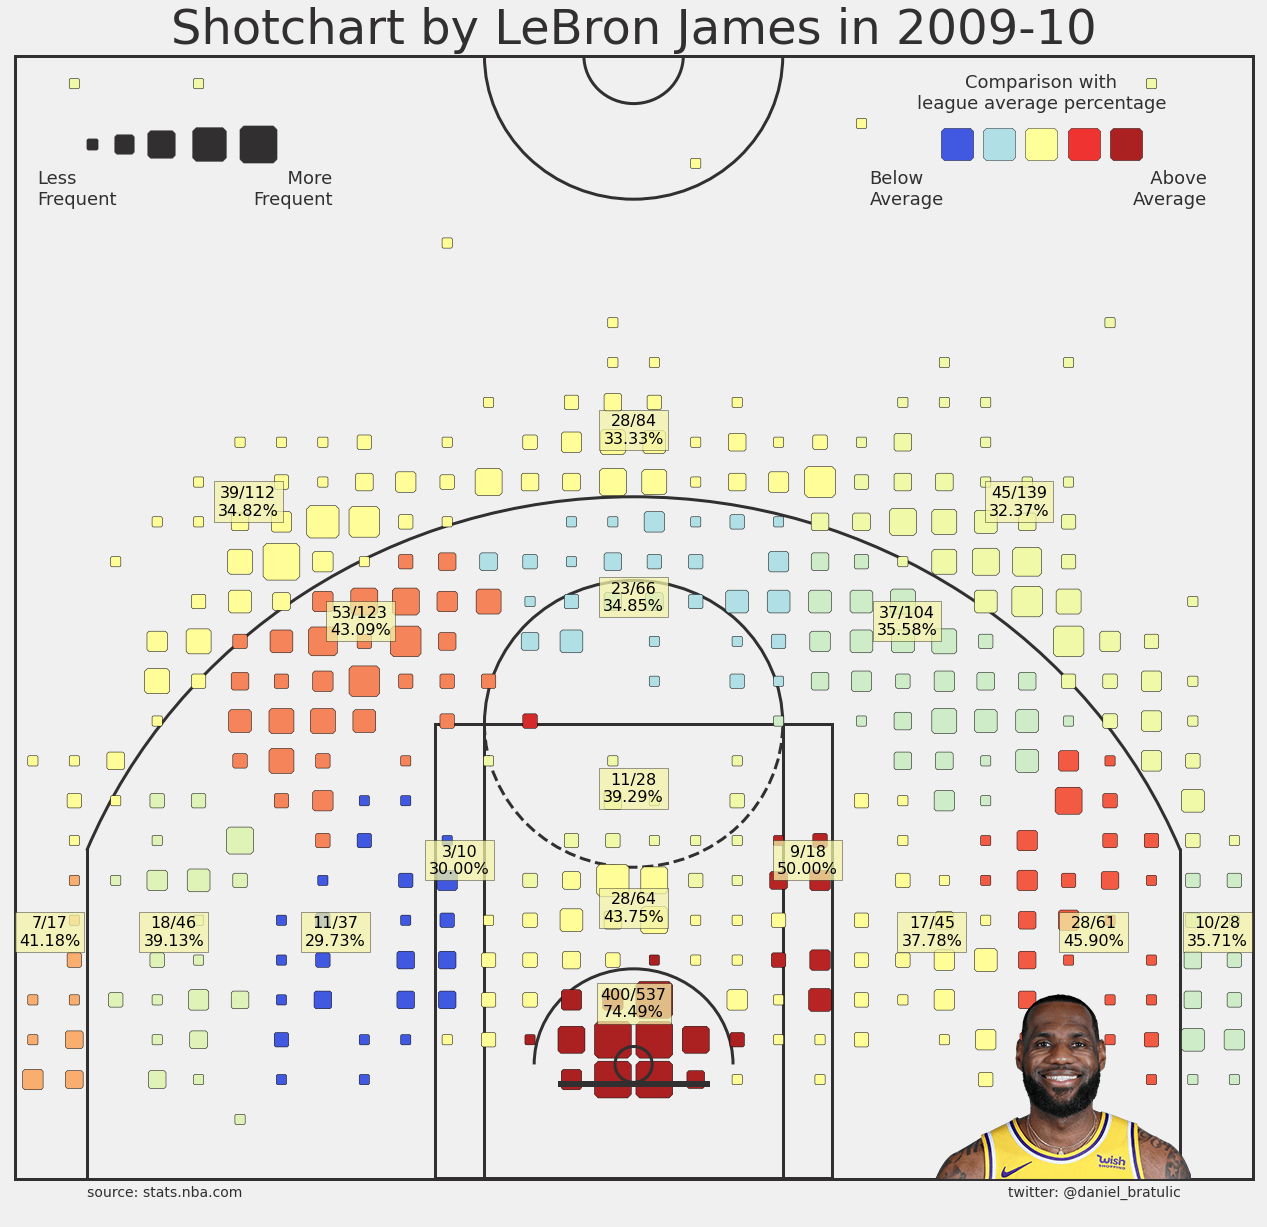

In [44]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)

### 2012-13

In [28]:
player_name = "LeBron James"
season = '2012-13'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [29]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

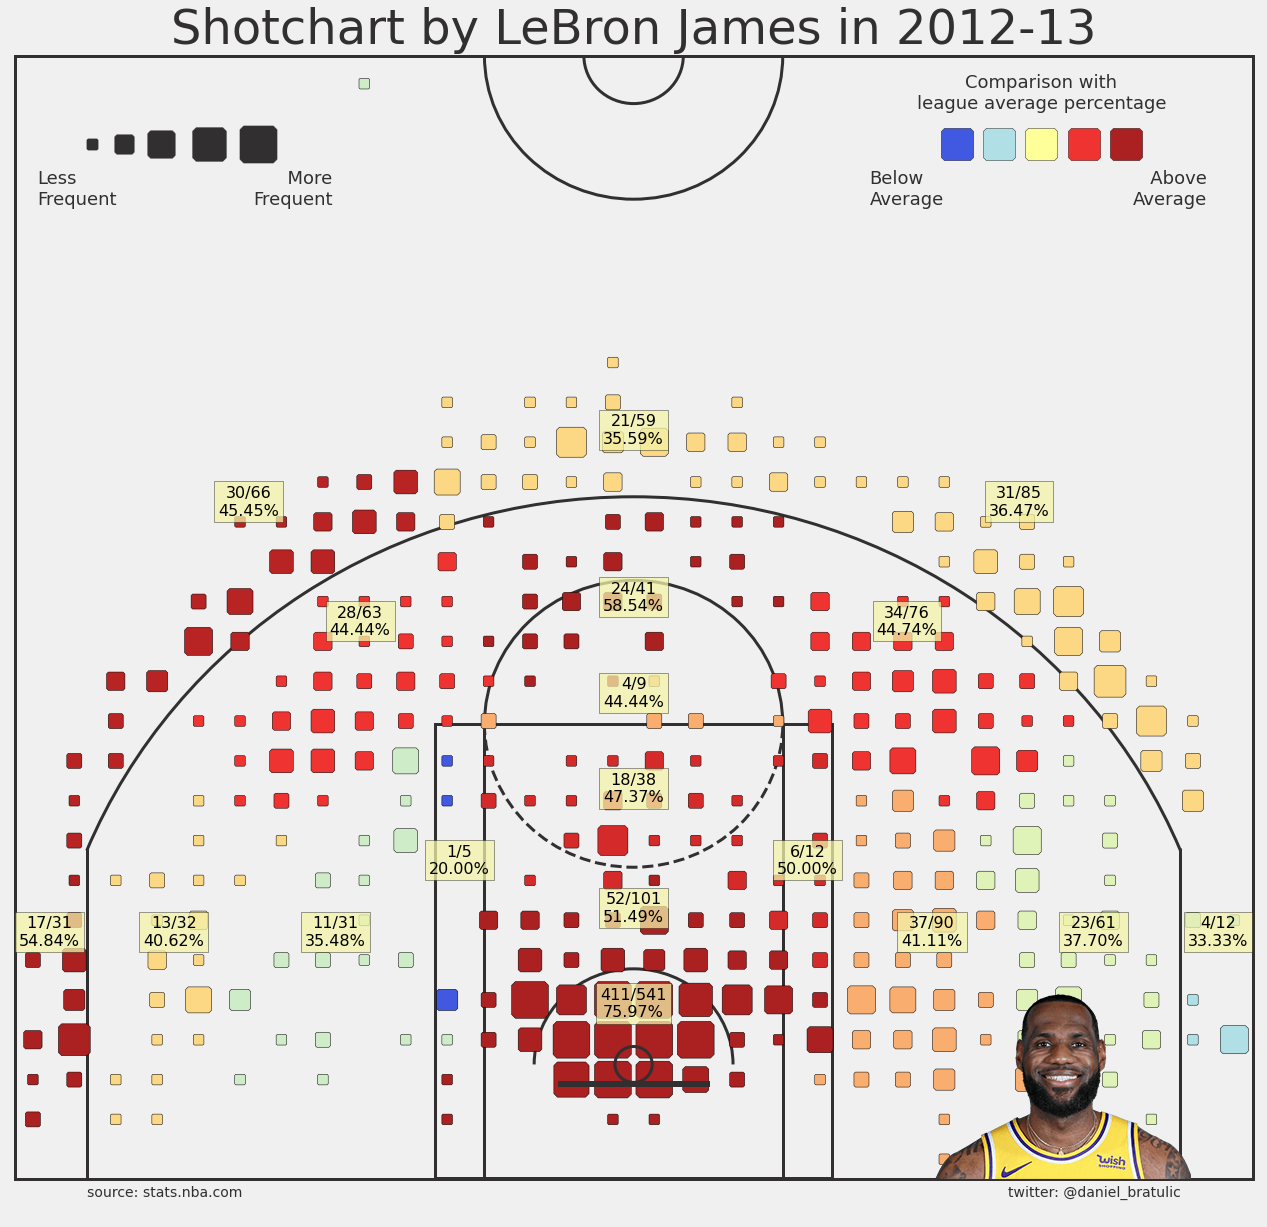

In [30]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)

### 2016-17

In [33]:
player_name = "LeBron James"
season = '2016-17'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [34]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

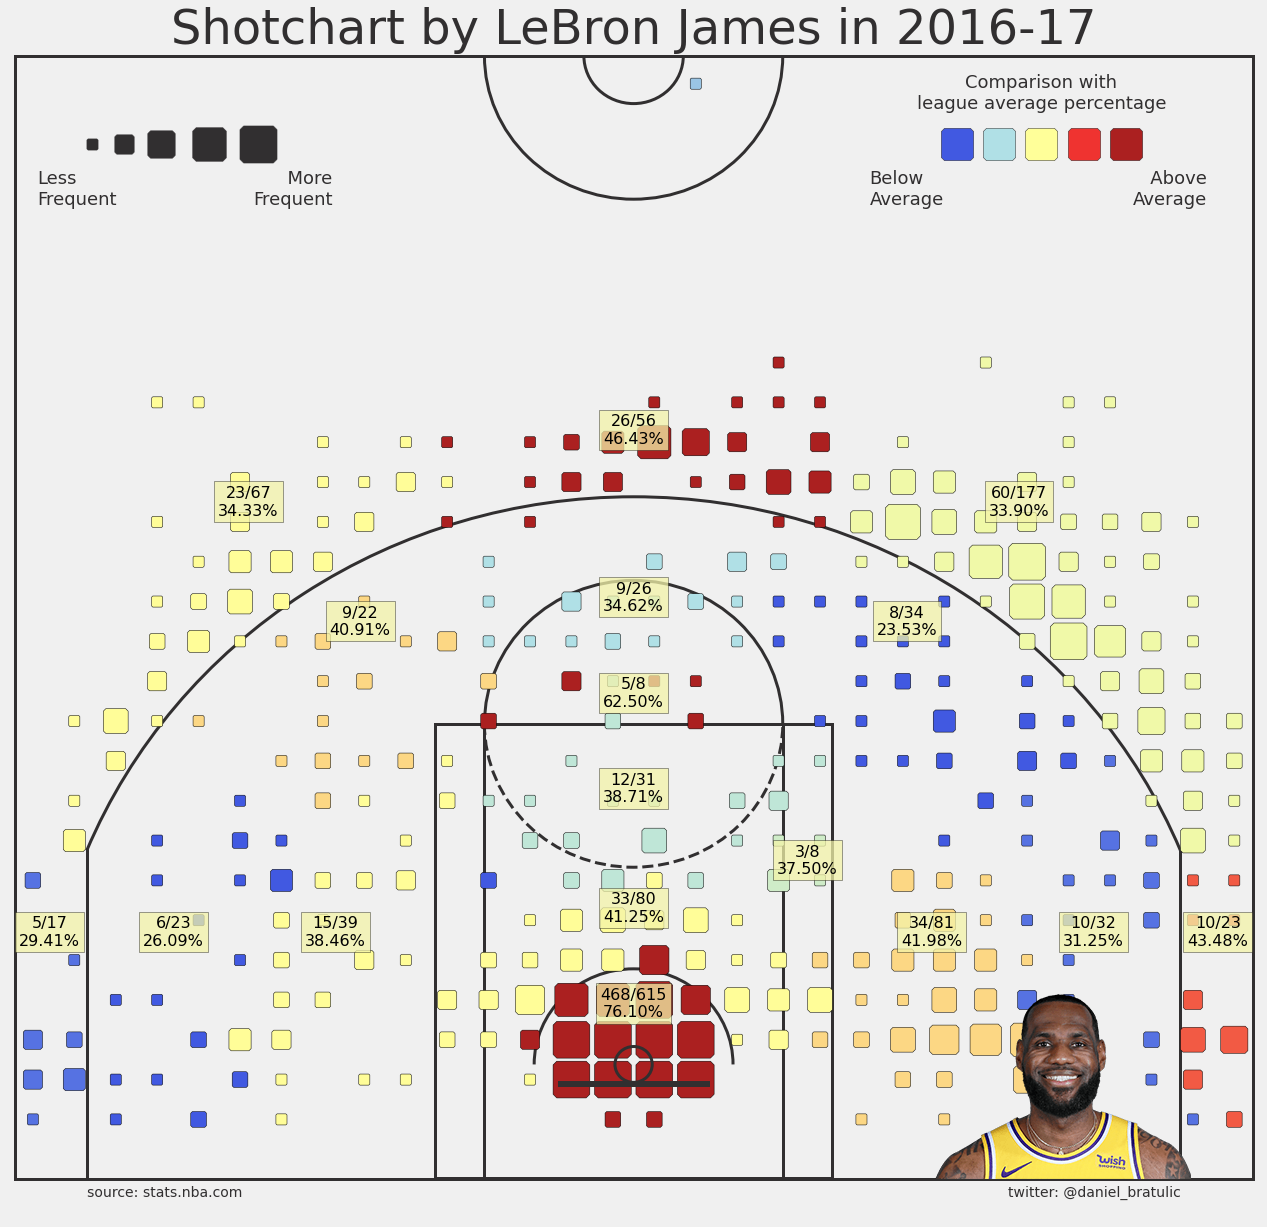

In [35]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)

### 2015-16

In [36]:
player_name = "LeBron James"
season = '2015-16'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [37]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

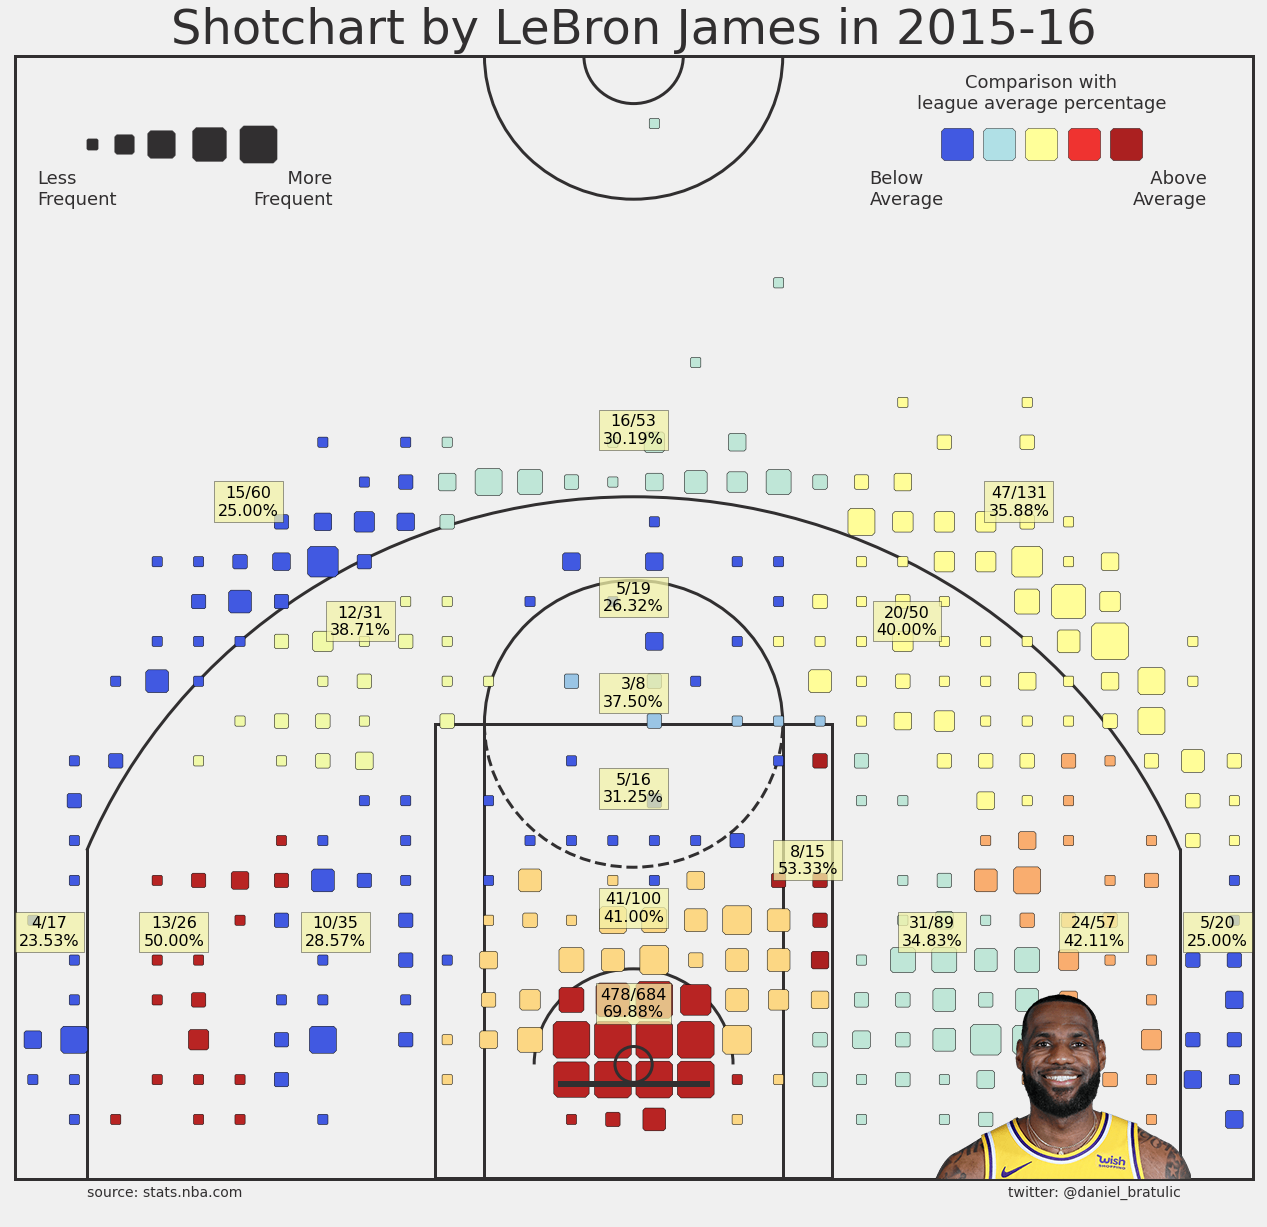

In [38]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)

### 2019-20

In [39]:
player_name = "LeBron James"
season = '2019-20'
player_id = find_players_by_full_name(player_name)[0]['id']


player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable=season)

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

league_avg = player_shotchart.get_data_frames()[1]

In [40]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

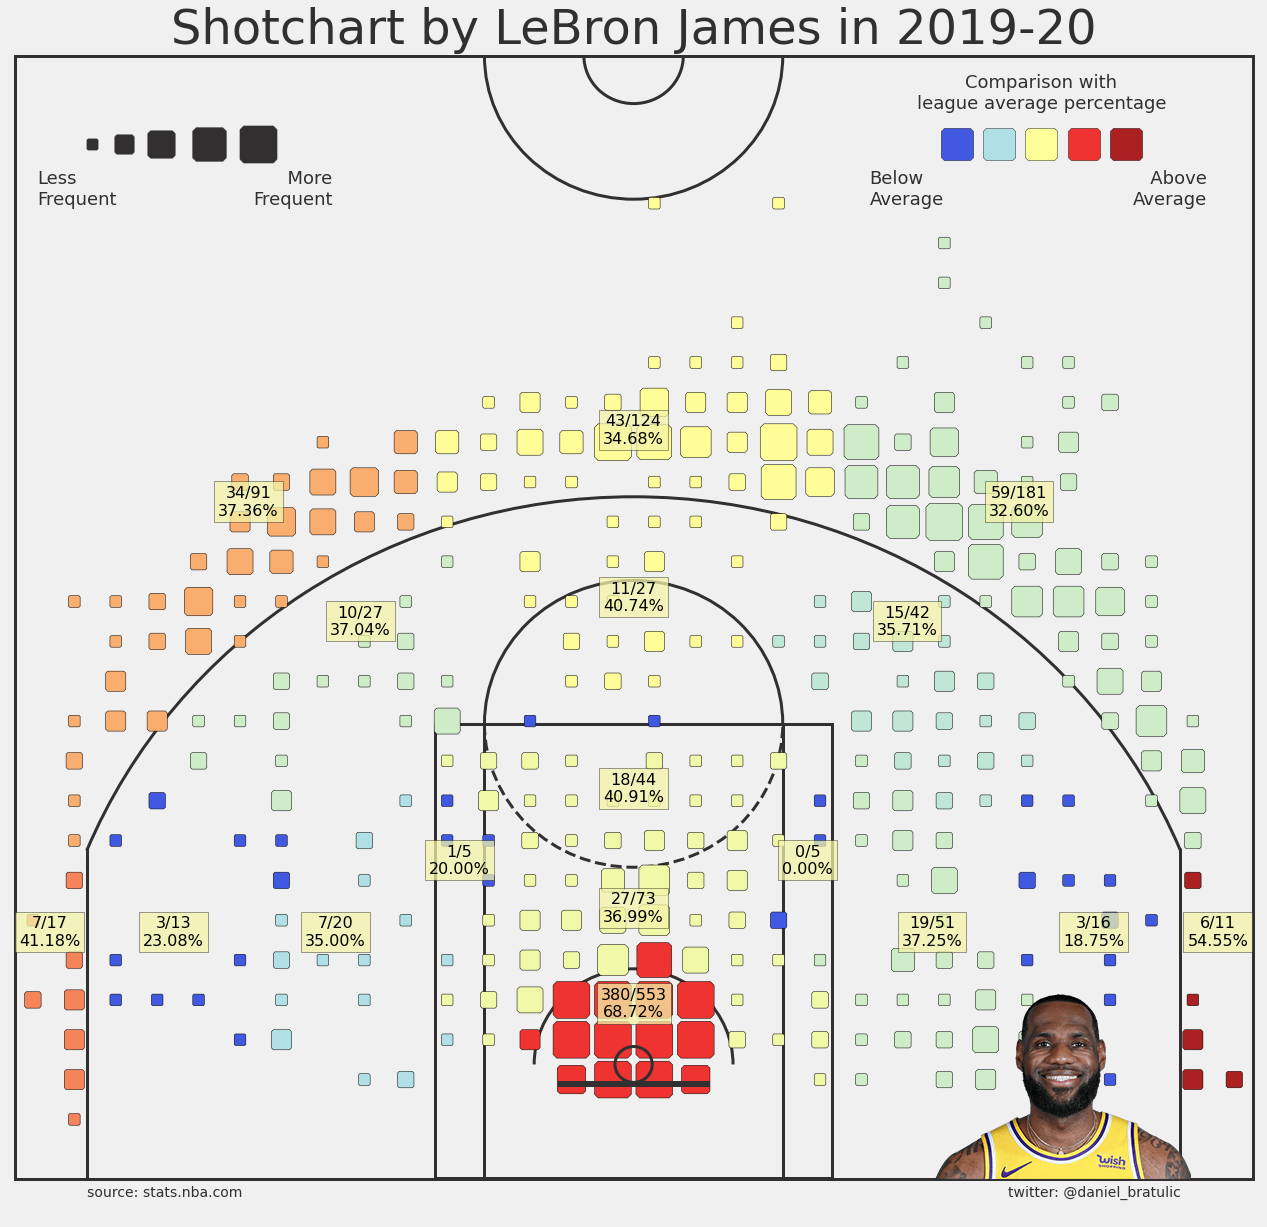

In [41]:
_ = plot_shotchart_light(player_df, binned_df, title=f'Shotchart by {player_name} in {season}', season=season, plot_attempts=True)